In [3]:
!pip install minisom
!pip install tslearn

  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=01b77b8c79ddd0354af72e029e5a82726b0845f202ee6c6f9567833e771e4486
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom
     |████████████████████████████████| 793 kB 7.4 MB/s 


In [4]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [79]:
df=pd.read_csv('co2_emission.csv')
del df['Code']
df['Year']=df['Year'].astype('str').astype('datetime64[ns]')
df.head()

,Entity,Year,Annual CO₂ emissions (tonnes )
0,Afghanistan,1949-01-01,14656.0
1,Afghanistan,1950-01-01,84272.0
2,Afghanistan,1951-01-01,91600.0
3,Afghanistan,1952-01-01,91600.0
4,Afghanistan,1953-01-01,106256.0


In [104]:
Series = []
Name_of_Country_Series = [] 
countries = df['Entity'].unique()
for country in countries:
  temp_df = df[df['Entity']==country]
  temp_df = temp_df.sort_values('Year')
  temp_df = temp_df.set_index('Year')
  if str(temp_df.index[0])<="1960-01-01":
    del temp_df['Entity']
    Series.append(temp_df['1960':])
    Name_of_Country_Series.append(country.lower())
print(len(Series))

countries = set([x.lower() for x in countries])

202


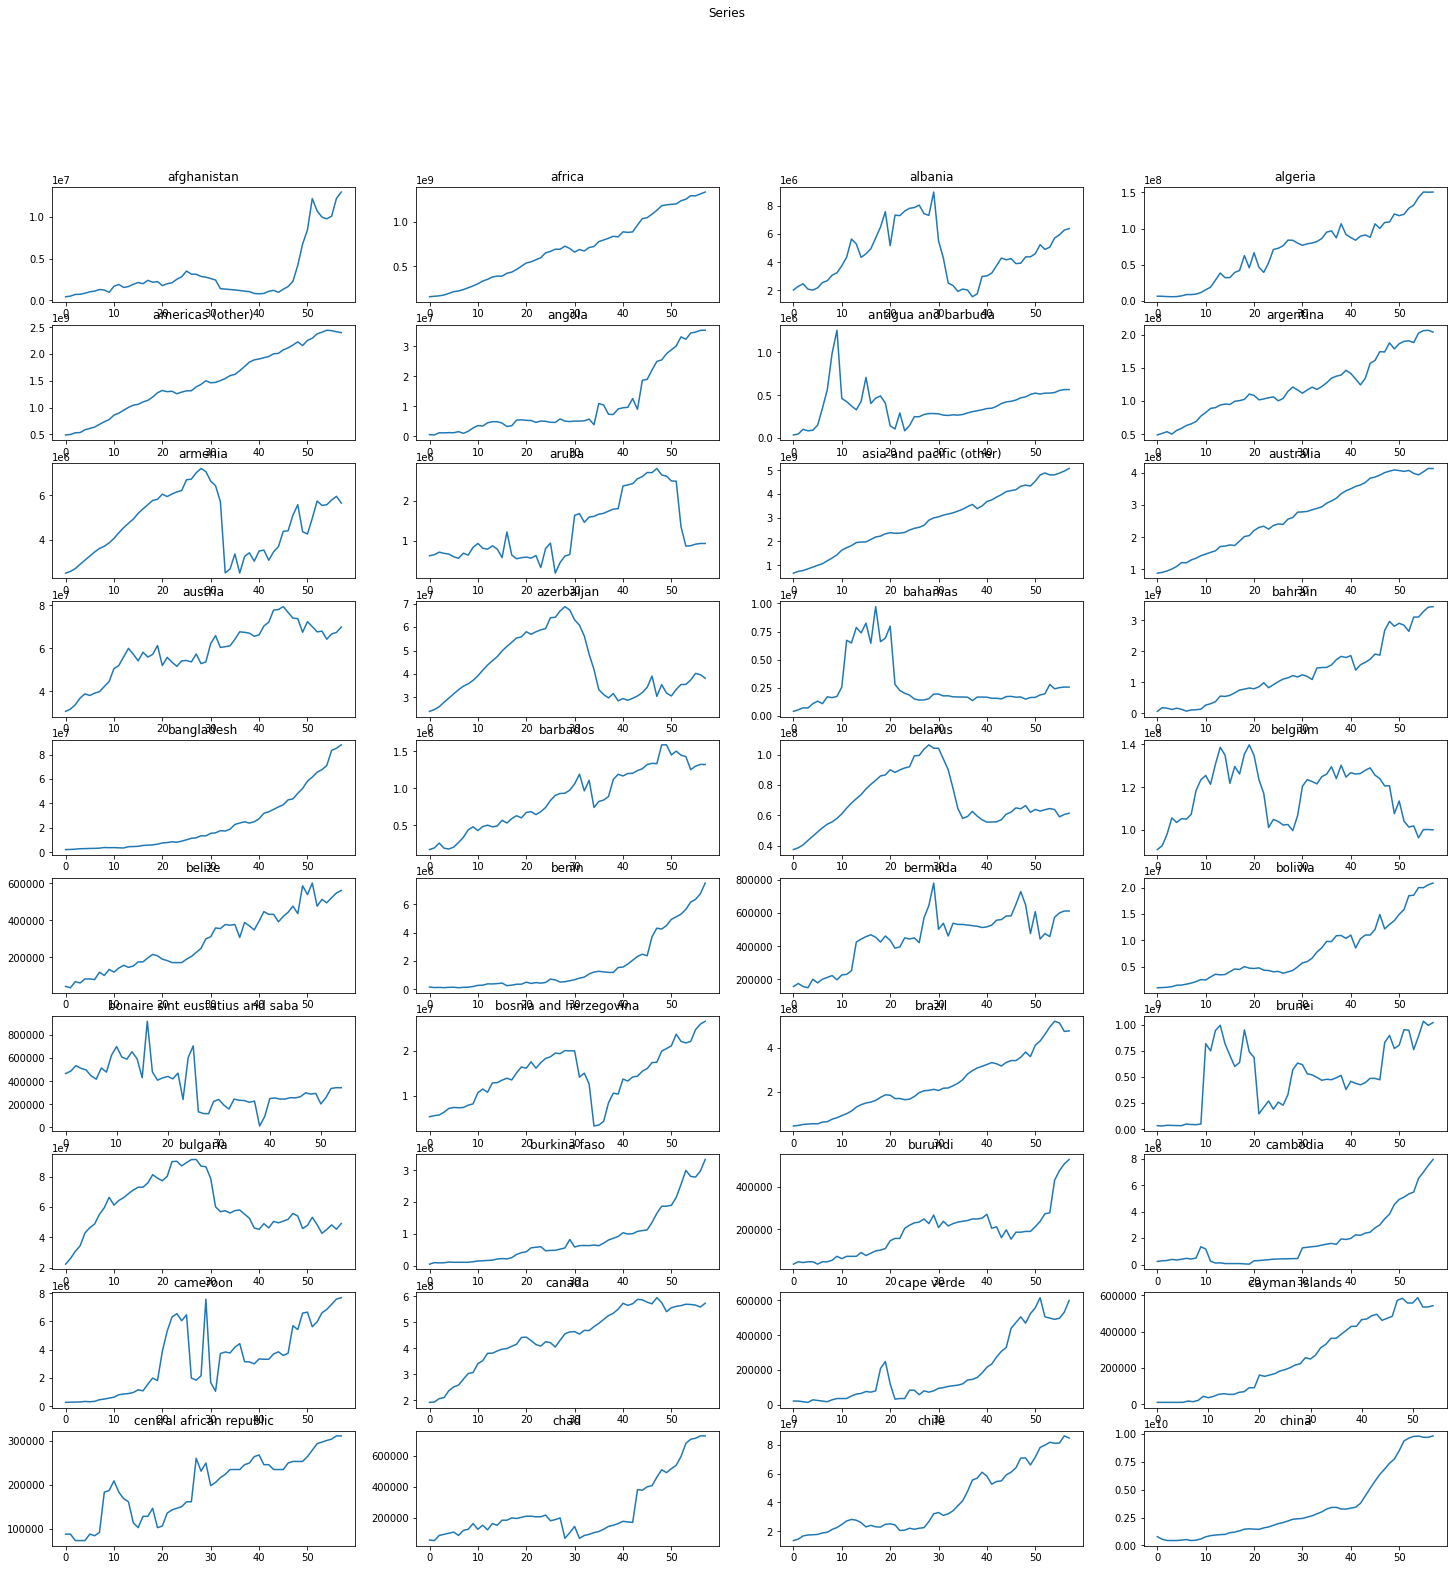

In [105]:
fig, axs = plt.subplots(10,4,figsize=(25,25))
fig.suptitle('Series')
for i in range(10):
    for j in range(4):
        if i*4+j+1>len(Series):
            continue
        axs[i, j].plot(Series[i*4+j].values)
        axs[i, j].set_title(Name_of_Country_Series[i*4+j])
plt.show()

In [106]:
for i in range(len(Series)):
  Series[i].interpolate(limit_direction="both",inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:10720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs,


In [107]:
#Here we were getting series with different lengths so we cleared the countries whose series lengths are < 58 
# and also cleared the null values.

empty_indices = []
for i in range(len(Series)):
  if Series[i]['Annual CO₂ emissions (tonnes )'].isnull().sum()>0 or len(Series[i])<58:
    empty_indices.append(i)
    print(Name_of_Country_Series[i])

for ss in empty_indices[::-1]:
  Series.pop(ss)
  Name_of_Country_Series.pop(ss)

bonaire sint eustatius and saba
cayman islands
czechoslovakia
eritrea
falkland islands
french guiana
gibraltar
guadeloupe
kyrgysztan
martinique
reunion
senegal
sint maarten (dutch part)
south sudan
sudan
swaziland
vietnam


In [108]:
for i in range(len(Series)):
    scaler = MinMaxScaler()
    Series[i] = MinMaxScaler().fit_transform(Series[i])
    Series[i] = Series[i].reshape(len(Series[i]))

In [109]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(Series))))
cluster_count = 2*math.ceil(math.sqrt(len(Series))) 
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
labels = km.fit_predict(np.array(Series))

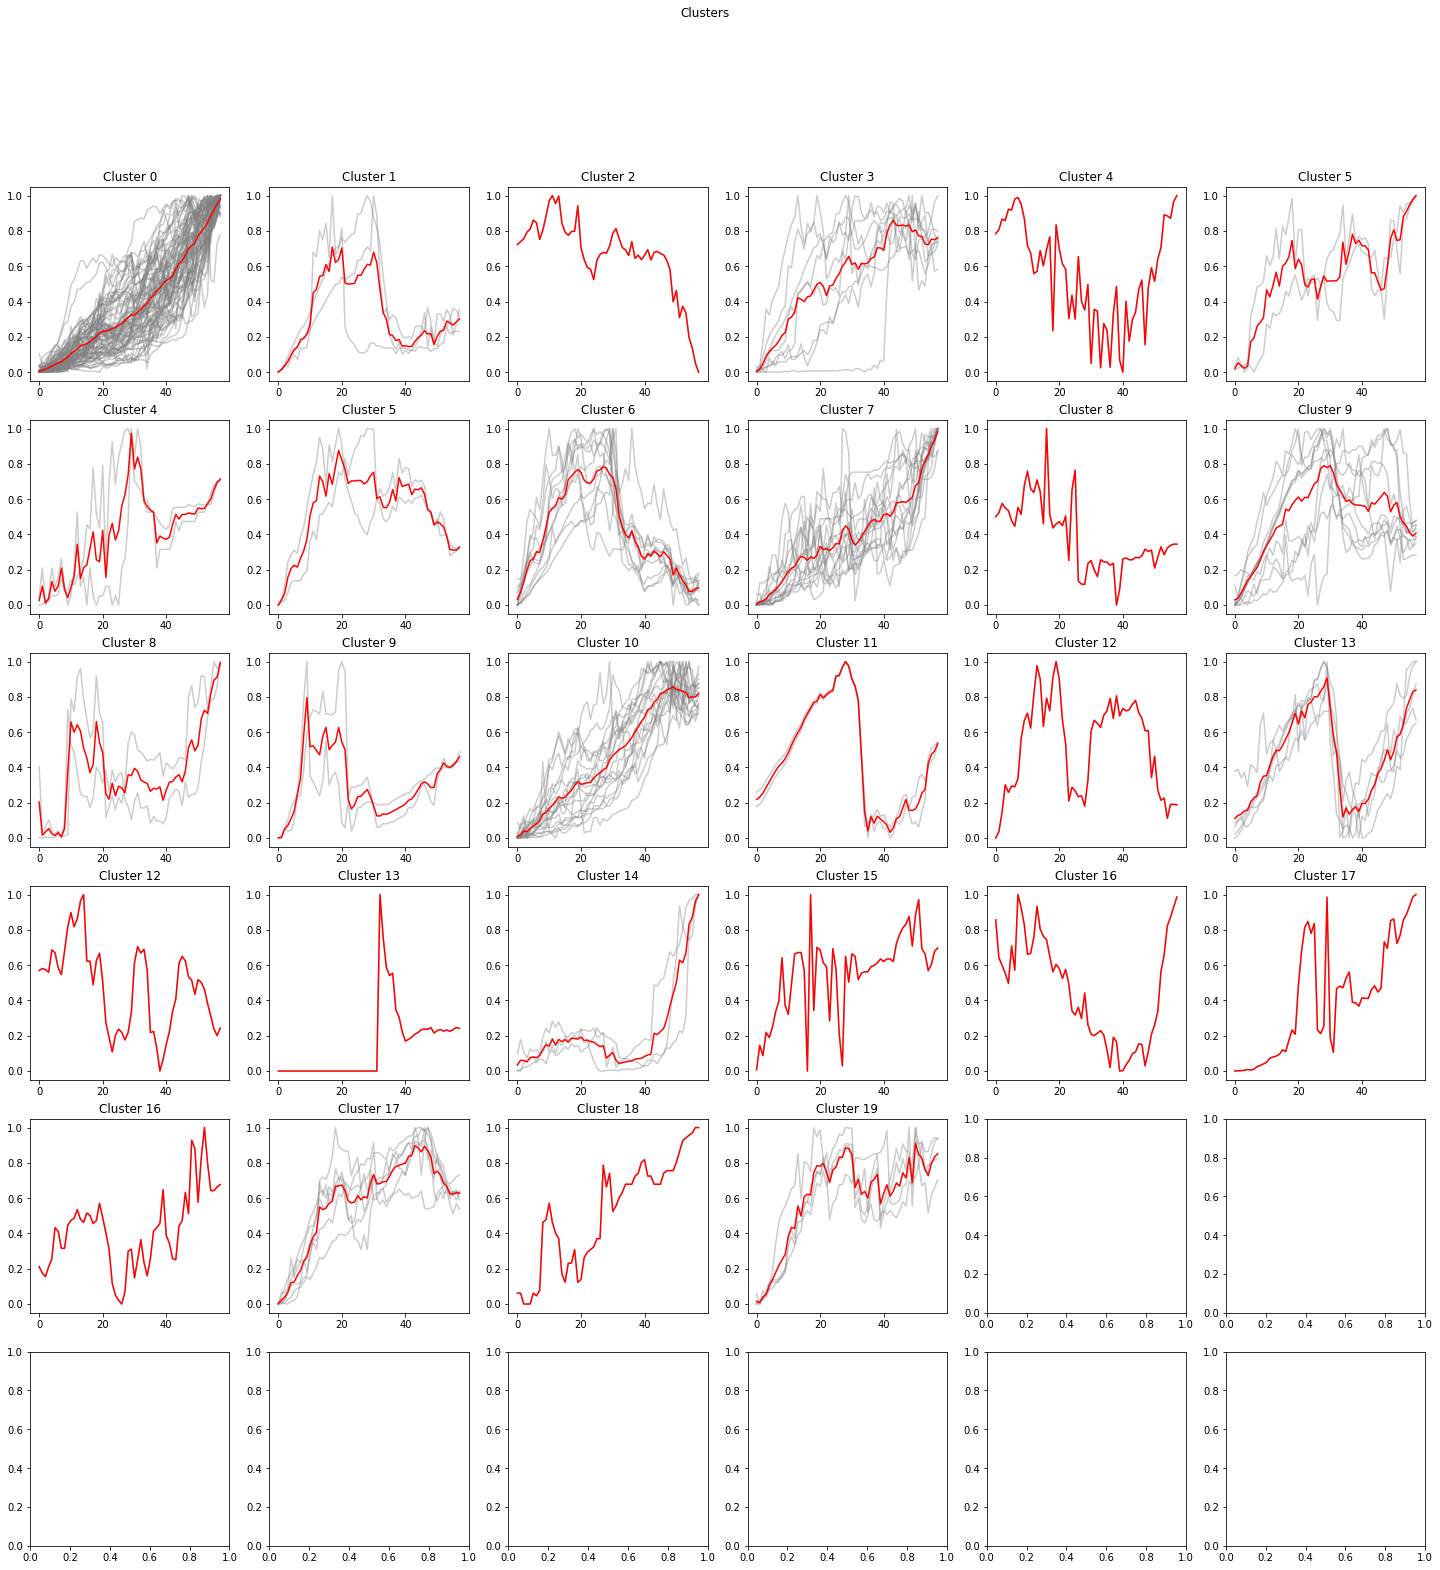

In [110]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(Series[i],c="gray",alpha=0.4)
                cluster.append(Series[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

In [112]:
clusters = {}
for label in set(labels):
  for i in range(len(Series)):
    if labels[i]==label:
      clusters[label] = clusters.get(label,[])+[Name_of_Country_Series[i]]

for i in clusters:
  print(i,clusters[i])

0 ['africa', 'americas (other)', 'angola', 'argentina', 'asia and pacific (other)', 'australia', 'bahrain', 'bangladesh', 'benin', 'bolivia', 'brazil', 'burkina faso', 'cambodia', 'canada', 'chile', 'china', 'colombia', 'comoros', 'costa rica', 'djibouti', 'dominica', 'dominican republic', 'ecuador', 'egypt', 'el salvador', 'ethiopia', 'french polynesia', 'gambia', 'ghana', 'guatemala', 'guinea', 'guinea-bissau', 'haiti', 'honduras', 'hong kong', 'iceland', 'india', 'international transport', 'iran', 'japan', 'laos', 'malawi', 'malaysia', 'mali', 'mauritius', 'mexico', 'middle east', 'mongolia', 'morocco', 'myanmar', 'nepal', 'new zealand', 'pakistan', 'panama', 'papua new guinea', 'paraguay', 'peru', 'philippines', 'qatar', 'rwanda', 'saint lucia', 'samoa', 'sao tome and principe', 'saudi arabia', 'solomon islands', 'south africa', 'south korea', 'sri lanka', 'taiwan', 'thailand', 'togo', 'tonga', 'tunisia', 'turkey', 'turkmenistan', 'uganda', 'united arab emirates']
1 ['azerbaijan', 

In [126]:
df2=pd.DataFrame()
df2.insert(0,"Cluster",[])
df2.insert(1,"Country_Name",[])
df2.insert(2,"Code",[])
df2.insert(3,"Option",[])
df2

,Cluster,Country_Name,Code,Option


In [128]:
new_df=pd.read_csv("co2_emission.csv")
for i in clusters:
  li=clusters[i]
  for country in li:
    for ind in new_df.index:
      if (new_df["Entity"][ind].lower()==country):
        df2=df2.append({'Cluster' : i, 'Country_Name' : country, 'Code' : new_df["Code"][ind], "Option" : 1},ignore_index=True)
        break
df2

,Cluster,Country_Name,Code,Option,Timepass
0,0.0,africa,NaN,NaN,1.0
1,0.0,americas (other),NaN,NaN,1.0
2,0.0,angola,AGO,NaN,1.0
3,0.0,argentina,ARG,NaN,1.0
4,0.0,asia and pacific (other),NaN,NaN,1.0
...,...,...,...,...,...
235,26.0,central african republic,CAF,1.0,NaN
236,27.0,cuba,CUB,1.0,NaN
237,27.0,montenegro,MNE,1.0,NaN
238,27.0,serbia,SRB,1.0,NaN


In [125]:
from google.colab import files

df2.to_csv('clusters.csv', encoding = 'utf-8-sig') 
files.download('clusters.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>